#ADVANCED HOUSE PRICE PREDICTION#

##INTRODUCTION

A comprehensive dataset containing 81 features and 1,460 entries on house prices is provided, divided into training and test sets. The objective is to develop a predictive model to estimate house prices and to perform feature analysis to identify the most significant variables influencing price predictions.

###IMPORTING NECESSARY LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from statsmodels.tools import add_constant
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from collections import Counter
from pprint import pprint

###IMPORTING THE DATASETS

In [ ]:
data_original = pd.read_csv('/content/train.csv')
data_train = data_original.copy()
data_test = pd.read_csv('/content/test.csv')
data_test['SalePrice'] = np.zeros(len(data_test))
data_train["Dataset"] = "train"
data_test["Dataset"] = "test"
data = pd.concat([data_train, data_test], ignore_index=True)

##ANALYSIS

###HANDLING DATA TYPES

The First column though being a Categorical Feature is encoded numerically and has no interpretetion. So it is converted into Categorical data type

In [ ]:
data[data.columns[1]] = data[data.columns[1]].astype('category')

All the columns of 'object' data types are converted into categorical data types

In [ ]:
for col in data.columns:
  if(data[col].dtype == 'O'):
    data[col] = data[col].astype('category')

###HANDLING MISSING VALUES

Two DataFrames are created, one containing numerical features with missing values and another containing categorical features with missing values.

In [ ]:
numeric = pd.DataFrame()
categorical = pd.DataFrame()
for col in data.columns:
    if data[col].dtype == 'category' and data[col].isna().sum() > 0:
        categorical[col] = data[col]
    elif (data[col].dtype == 'float64' or data[col].dtype == 'int64') and data[col].isna().sum() > 0:
        numeric[col] = data[col]

Analyzing the missing value patterns for the categorical Features.

In [ ]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   MSZoning      2915 non-null   category
 1   Alley         198 non-null    category
 2   Utilities     2917 non-null   category
 3   Exterior1st   2918 non-null   category
 4   Exterior2nd   2918 non-null   category
 5   MasVnrType    1153 non-null   category
 6   BsmtQual      2838 non-null   category
 7   BsmtCond      2837 non-null   category
 8   BsmtExposure  2837 non-null   category
 9   BsmtFinType1  2840 non-null   category
 10  BsmtFinType2  2839 non-null   category
 11  Electrical    2918 non-null   category
 12  KitchenQual   2918 non-null   category
 13  Functional    2917 non-null   category
 14  FireplaceQu   1499 non-null   category
 15  GarageType    2762 non-null   category
 16  GarageFinish  2760 non-null   category
 17  GarageQual    2760 non-null   category
 18  GarageCo

The following informations are priovided in the data dictionary

Alley: Type of alley access to property
       
       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches)
       NA	No Basement              
same for the next basement related columns representing features of basement and NAN values implies absence of basement.

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
Foe this case the NAN value seems to be inconsistent and has to be checked.

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

For the Garage related columns and the remaining column the NAN values represent the absence of that specific feature

In [ ]:
for col in categorical.columns[range(23)]:
  data[col] = data[col].cat.add_categories(['Absent'])
  data[col] = data[col].fillna('Absent')

Checking for Pattern and distribution of missing values for the numeric fetaures.

In [ ]:
numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   2433 non-null   float64
 1   MasVnrArea    2896 non-null   float64
 2   BsmtFinSF1    2918 non-null   float64
 3   BsmtFinSF2    2918 non-null   float64
 4   BsmtUnfSF     2918 non-null   float64
 5   TotalBsmtSF   2918 non-null   float64
 6   BsmtFullBath  2917 non-null   float64
 7   BsmtHalfBath  2917 non-null   float64
 8   GarageYrBlt   2760 non-null   float64
 9   GarageCars    2918 non-null   float64
 10  GarageArea    2918 non-null   float64
dtypes: float64(11)
memory usage: 251.0 KB


In [ ]:
print("\nMissing LotFrontage by LotShape:")
print(data['LotShape'].value_counts())
print(data.groupby('LotShape', observed=True)['LotFrontage'].apply(lambda x: x.isna().sum()))

LotShape
Reg    1859
IR1     968
IR2      76
IR3      16
Name: count, dtype: int64
LotShape
IR1    321
IR2     28
IR3      5
Reg    132
Name: LotFrontage, dtype: int64

Missing LotFrontage by LotShape:


It could be seen from the proportion of missing values in Lot Frontage with respect to the Lot shape that the proportion of missing values is high in Irregular lot shape. This implies missing is non random and may be due to the irregular shape of lot, it was difficult to note down the lot frontage.

In [ ]:
print(data['LotConfig'].value_counts())
print(data.groupby('LotConfig', observed=True)['LotFrontage'].apply(lambda x: x.isna().sum()))
print("\nMissing LotFrontage by LotConfig:")

LotConfig
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: count, dtype: int64
LotConfig
Corner     104
CulDSac     87
FR2         20
FR3          4
Inside     271
Name: LotFrontage, dtype: int64

Missing LotFrontage by LotConfig:


<Axes: xlabel='LotFrontage', ylabel='Count'>

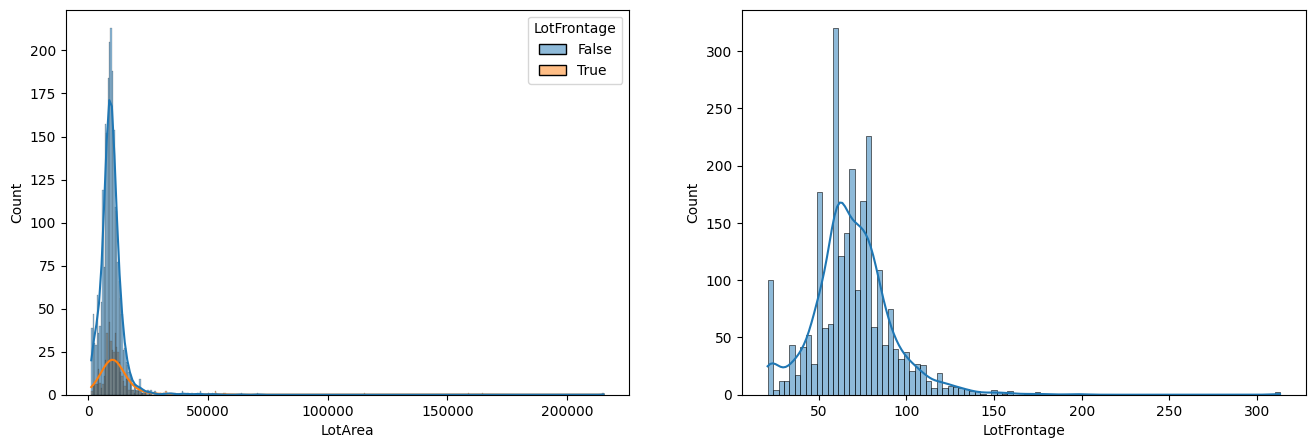

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(data=data, x='LotArea', hue=data['LotFrontage'].isna(), kde=True, ax=axes[0])
sns.histplot(data=data, x='LotFrontage', kde=True, ax=axes[1])

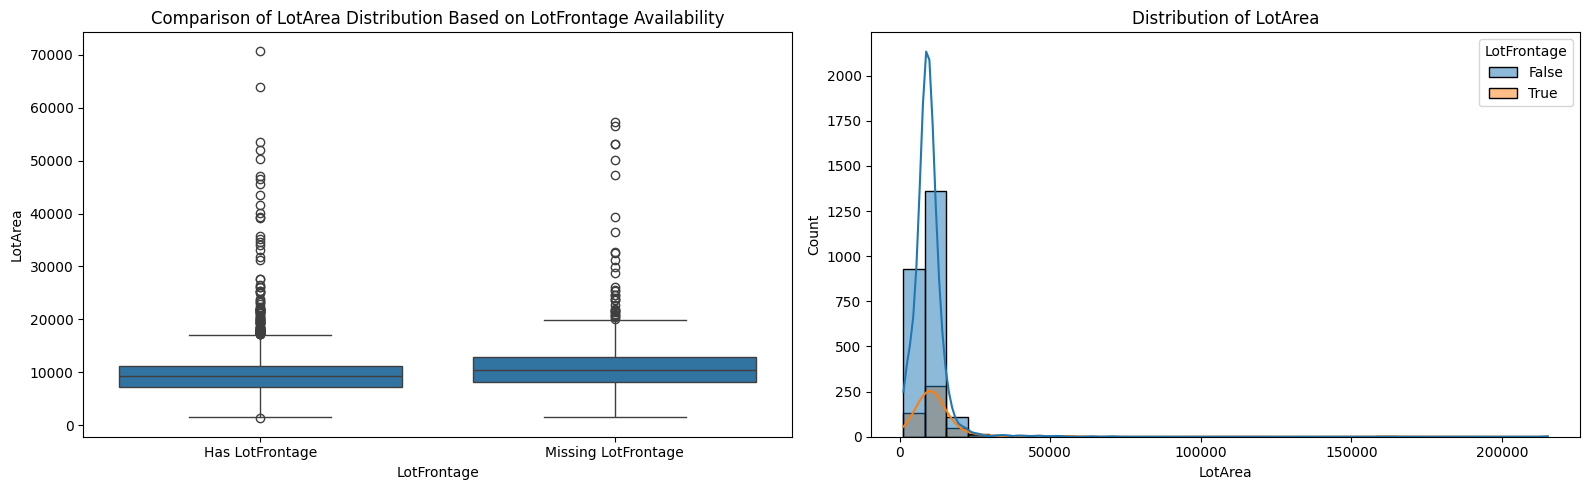

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.boxplot(x=data['LotFrontage'].isna(),  y=data[data['LotArea']<100000]['LotArea'], ax=axes[0])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Has LotFrontage', 'Missing LotFrontage'])
axes[0].set_ylabel("LotArea")
axes[0].set_title("Comparison of LotArea Distribution Based on LotFrontage Availability")
# Histogram: Log-Transformed LotArea Distribution
sns.histplot(data, x='LotArea', hue=data['LotFrontage'].isna(), kde=True, bins=30, ax=axes[1])
axes[1].set_title("Distribution of LotArea")
axes[1].set_xlabel("LotArea")

plt.tight_layout()
plt.show()

Random forest imputation is done to fill the mising values

In [ ]:
lot = data[['Id','LotFrontage', 'LotArea', 'LotConfig', 'LotShape']]
train_data = lot[lot['LotArea']<100000].dropna(subset=['LotFrontage'])
test_data = lot.loc[lot['LotFrontage'].isna()]
train_data = pd.get_dummies(train_data, columns=['LotShape', 'LotConfig'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['LotShape', 'LotConfig'], drop_first=True)
X_train = train_data.drop(['Id','LotFrontage', 'LotShape_Reg', 'LotConfig_FR2', 'LotConfig_FR3'], axis=1)
X_test = test_data.drop(['Id','LotFrontage', 'LotShape_Reg', 'LotConfig_FR2', 'LotConfig_FR3'],axis=1)
y_train = train_data['LotFrontage']

In [ ]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=7, min_samples_split=3, random_state=42)
rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"R² Score on Train Data: {r2_train:.4f}")

R² Score on Train Data: 0.6699


In [ ]:
test_data['LotFrontage'] = rf_model.predict(X_test)
data.loc[data['LotFrontage'].isna(), 'LotFrontage'] = test_data['LotFrontage']

Checking the missing values in MasVnrArea by MasVnrType.

In [ ]:
print(data['MasVnrType'].value_counts())
print(data.groupby('MasVnrType', observed=True)['MasVnrArea'].apply(lambda x: x.isna().sum()))
print("\nMissing MasVnrArea by Type:")

MasVnrType
Absent     1766
BrkFace     879
Stone       249
BrkCmn       25
Name: count, dtype: int64
MasVnrType
BrkCmn      0
BrkFace     0
Stone       0
Absent     23
Name: MasVnrArea, dtype: int64

Missing MasVnrArea by Type:


It could be seen that those where MasVnrType is absent, there only MasVnrArea is missing. Hence t could be imputed as 0

In [ ]:
data.loc[(data['MasVnrType'] == 'Absent') & (data['MasVnrArea'] > 0), 'MasVnrArea'] = 0.0
data['MasVnrArea'] = data['MasVnrArea'].fillna(0.0)

YearBuilt: Original construction date

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

Same are done for other numeric columns which have missing values due to the absence of respective attribute

In [ ]:
data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']] = data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']].fillna(0.0)

The missing values in GarageYrBlt is replaced by the construction year of the house.

In [ ]:
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['YearBuilt'])

###FEATURE ENGINEERING

Converting the Year columns to age columns for relevancy in modelling

In [ ]:
data['HouseAge'] = data['YrSold'] - data['YearBuilt']
data['RemodelAge'] = data['YrSold'] - data['YearRemodAdd']
data['GarageAge'] = data['YrSold'] - data['GarageYrBlt']
data = data.drop(['YearBuilt', 'YrSold','RemodelAge','GarageYrBlt'],axis=1)

####ORDINAL ENCODING FOR QUALITATIVE VARIABLES

In [ ]:
ranking_mappings = {
'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Absent': 0},
'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Absent': 0},
'GarageFinish':{'Fin':3, 'RFn':2, 'Unf':1, 'Absent':0 },
'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Absent': 0},
'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Absent': 0},
'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Absent': 0},
'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'Absent': 0},
'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Absent': 0},
'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Absent': 0},
'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Absent': 0},
'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Absent': 0},
'PoolQC' :    {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Absent': 0}
}

for col, mapping in ranking_mappings.items():
    data[col] = data[col].map(mapping)
    data[col] = data[col].astype('int64')

transforming basement related columns, neighbourhood related columns, exterior related columns, garage related, porch related columns

The Neighborhood column is categorical and has high cardinality. In case of modelling the one hot encoding of this column would create many dummy variables and the dimensionality will increase. The number of entries is less. Hence the neighborhood levels are clustered according to area with repect to Selling Price.

In [ ]:
train = data[data['Dataset'] == 'train']

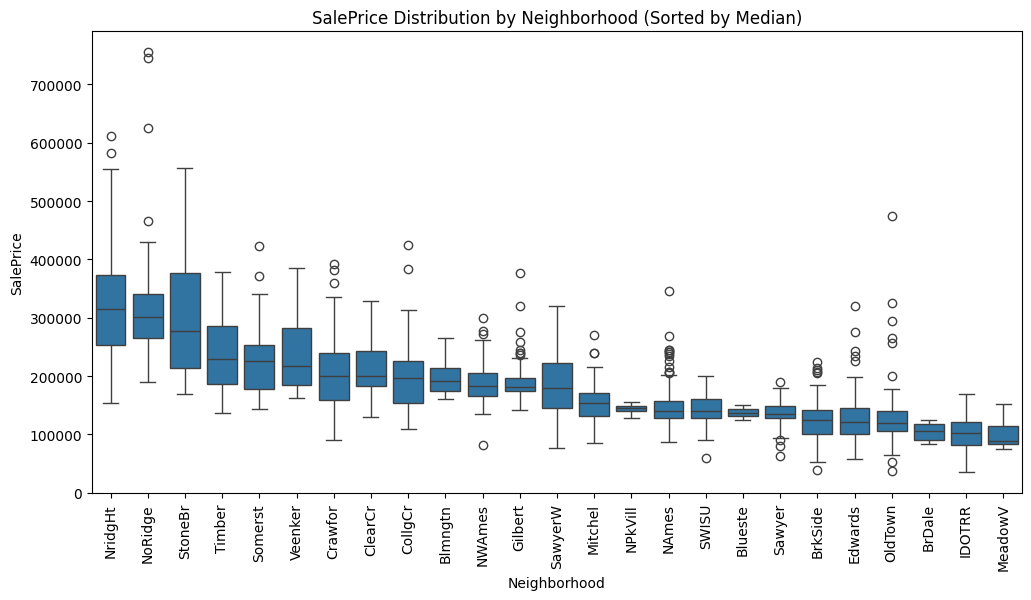

In [ ]:
plt.figure(figsize=(12, 6))
sorted_neighborhoods = train.groupby('Neighborhood', observed = True)['SalePrice'].median().sort_values(ascending=False).index
sns.boxplot(x='Neighborhood', y='SalePrice', data=train, order=sorted_neighborhoods)
plt.xticks(rotation=90)
plt.title("SalePrice Distribution by Neighborhood (Sorted by Median)")
plt.show()

Performing Hirearchial clustering

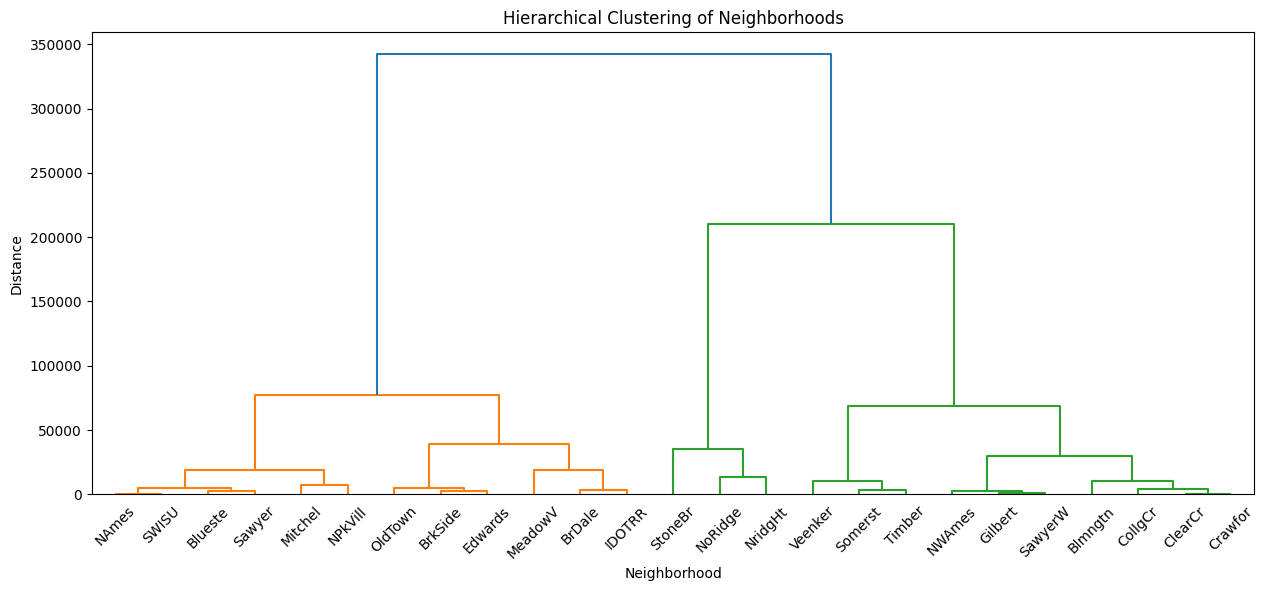

In [ ]:
# Compute mean logSalePrice for each neighborhood
grouped_data = train.groupby('Neighborhood', observed = True)['SalePrice'].median()
# Perform hierarchical clustering
linked = linkage(grouped_data.values.reshape(-1, 1), method='ward')
# Plot dendrogram
plt.figure(figsize=(15, 6))
dendrogram(linked, labels=grouped_data.index, orientation='top')
plt.title('Hierarchical Clustering of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Distance')
plt.show()

Validating the Groups and checking the groups are homogeneous within, using Kruskal Walis Test

In [ ]:
#Kruskal-Wallis test for Neighborhood
from scipy.stats import kruskal
Premium_Residential = ['NoRidge', 'NridgHt', 'StoneBr']
Upper_Mid_Residential = ['Somerst', 'Veenker', 'Timber']
Established_Suburban = ['Gilbert', 'NWAmes', 'SawyerW', 'Blmngtn', 'CollgCr', 'ClearCr', 'Crawfor']
Affordable_Residential = ['NAmes', 'SWISU', 'Blueste', 'Sawyer', 'NPkVill', 'Mitchel']
Older_Urban_Residential = ['OldTown', 'BrkSide', 'Edwards']
Industrial_Adjacent = ['MeadowV', 'BrDale', 'IDOTRR']
areas = [
    ('Premium Residential', Premium_Residential), ('Upper Mid Residential', Upper_Mid_Residential), ('Established Suburban', Established_Suburban),
    ('Affordable Residential', Affordable_Residential), ('Older Urban Residential', Older_Urban_Residential), ('Industrial Adjacent', Industrial_Adjacent)
]

#  Kruskal-Wallis Test
for name, area in areas:
    data1 = train[train['Neighborhood'].isin(area)]
    neighborhood_groups = [group['SalePrice'].values for _, group in data1.groupby('Neighborhood', observed=True)]

    # Check if at least 2 neighborhoods exist
    if len(neighborhood_groups) > 1:
        kw_neighborhood = kruskal(*neighborhood_groups)
        print(f"Kruskal-Wallis Test for {name}:")
        print(f"Statistic: {kw_neighborhood.statistic}, p-value: {kw_neighborhood.pvalue}\n")
    else:
        print(f"Skipping {name} (Only one neighborhood in this category)\n")


Kruskal-Wallis Test for Premium Residential:
Statistic: 0.8218193218791359, p-value: 0.6630468279226549

Kruskal-Wallis Test for Upper Mid Residential:
Statistic: 1.7333749077596374, p-value: 0.42034164668645835

Kruskal-Wallis Test for Established Suburban:
Statistic: 9.851194017635775, p-value: 0.13106005996671888

Kruskal-Wallis Test for Affordable Residential:
Statistic: 10.108460223278287, p-value: 0.07221976063863453

Kruskal-Wallis Test for Older Urban Residential:
Statistic: 0.19612061009246523, p-value: 0.9065942298984345

Kruskal-Wallis Test for Industrial Adjacent:
Statistic: 1.0129118200743306, p-value: 0.602627564909545



Based On the P-values we don't have enough evidence to reject the null hypothesis of homogeneous groups

In [ ]:
# Define the cluster conditions
conditions = [
    data['Neighborhood'].isin(Premium_Residential),
    data['Neighborhood'].isin(Upper_Mid_Residential),
    data['Neighborhood'].isin(Established_Suburban),
    data['Neighborhood'].isin(Affordable_Residential),
    data['Neighborhood'].isin(Older_Urban_Residential),
    data['Neighborhood'].isin(Industrial_Adjacent)
]

cluster_values = [6, 5, 4, 3, 2, 1]

data['Neighbourhood'] = np.select(conditions, cluster_values, default=np.nan)

**Premium Residential:** Located in the north, with upscale residential areas like NoRidge and StoneBr, characterized by spacious homes and luxurious amenities.

**Upper-Mid Residential:** Found in well-planned suburban communities like Somerst and Veenker, offering family-friendly environments and proximity to parks.

**Established Suburban:** Primarily suburban neighborhoods such as CollgCr and NWAmes, providing mid-range housing near schools and commercial hubs.

**Affordable Residential:** Spread across central and south Ames, areas like NAmes and SWISU feature student housing, affordable homes, and easy university access.

**Older Urban Residential:** Older neighborhoods like OldTown and BrkSide with historic charm, smaller homes, and close proximity to downtown.

**Industrial Adjacent:** Industrial and lower-income areas like IDOTRR and MeadowV, often near railroads and commercial zones with lower property values.

Same as Neighborhood column, there are Two columns named 'Condition1' and 'Condition2'. The columns give information about some specific regions adjacent to the house which may affect the price. 'Condition-1' represent the most adjacent region.'Condition-2' represent some other region adjacent to the house. If there is only one adjacent region the entries of both the columns are same. Hence an interaction column is created concatenating the two columns

In [ ]:
def create_interaction(row):
    if row['Condition1'] == row['Condition2']:
        return row['Condition1']
    else:
        return f"{row['Condition1']}_{row['Condition2']}"

data['Condition_Interaction'] = data.apply(create_interaction, axis=1)

Performing clustering on the Condition column to reduce cardinality

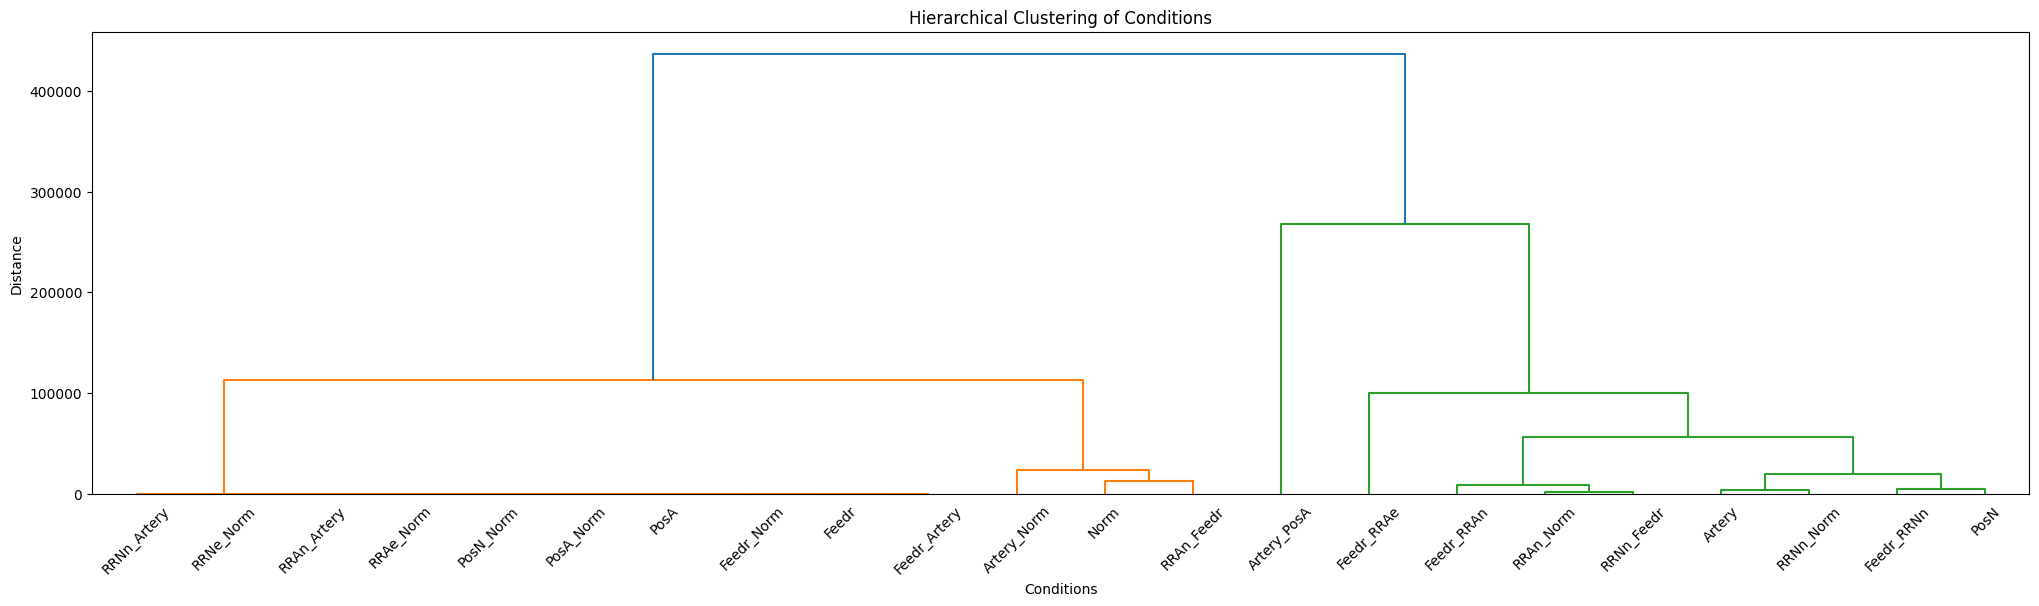


Cluster 1:
['Feedr', 'Feedr_Artery', 'Feedr_Norm', 'PosA', 'PosA_Norm', 'PosN_Norm', 'RRAe_Norm', 'RRAn_Artery', 'RRNe_Norm', 'RRNn_Artery']

Cluster 2:
['Artery_Norm', 'Norm', 'RRAn_Feedr']

Cluster 3:
['Artery', 'Feedr_RRAe', 'Feedr_RRAn', 'Feedr_RRNn', 'PosN', 'RRAn_Norm', 'RRNn_Feedr', 'RRNn_Norm']

Cluster 4:
['Artery_PosA']


In [ ]:
def create_interaction(row):
    if row['Condition1'] == row['Condition2']:
        return row['Condition1']
    else:
        return f"{row['Condition1']}_{row['Condition2']}"

data['Condition_Interaction'] = data.apply(create_interaction, axis=1)
grouped_data = data.groupby('Condition_Interaction', observed = True)['SalePrice'].median()
linked = linkage(grouped_data.values.reshape(-1, 1), method='ward')


plt.figure(figsize=(25, 6))
dendrogram(linked, labels=grouped_data.index, orientation='top')
plt.title('Hierarchical Clustering of Conditions')
plt.xlabel('Conditions')
plt.ylabel('Distance')
plt.show()

clusters = fcluster(linked, 4, criterion='maxclust')

cluster_df = pd.DataFrame({'Condition_Interaction': grouped_data.index, 'Cluster': clusters})

for cluster_num, group in cluster_df.groupby('Cluster'):
    print(f"\nCluster {cluster_num}:")
    print(group['Condition_Interaction'].tolist())

In [ ]:
train = data[data['Dataset']== 'train']

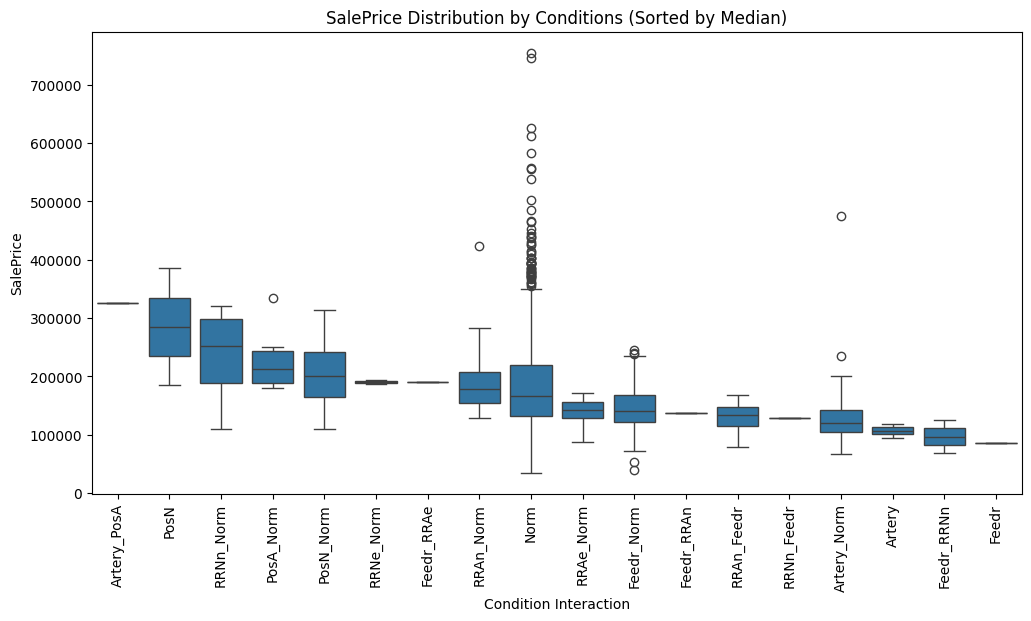

In [ ]:
plt.figure(figsize=(12, 6))
sorted_conds = train.groupby('Condition_Interaction')['SalePrice'].median().sort_values(ascending=False).index
sns.boxplot(x='Condition_Interaction', y='SalePrice', data=train, order=sorted_conds)
plt.xticks(rotation=90)
plt.title("SalePrice Distribution by Conditions (Sorted by Median)")
plt.xlabel("Condition Interaction")
plt.ylabel("SalePrice")
plt.show()

Validating the groups for homogeneity using Kruskal walis test

In [ ]:
gr1 = ['Norm']
gr2 = ['Artery_PosA', 'PosN', 'RRNn_Norm', 'PosA_Norm', 'PosN_Norm','PosA']
gr3 = ['Feedr_RRAe', 'RRAn_Norm', 'RRNe_Norm']
gr5 = ['Artery', 'Feedr', 'Feedr_RRNn','Feedr_Artery']
gr4 = ['Artery_Norm', 'Feedr_Norm', 'Feedr_RRAn', 'RRAe_Norm', 'RRAn_Feedr', 'RRNn_Feedr', 'RRNn_Artery','RRAn_Artery']
areas = [ ('gr1', gr1), ('gr2', gr2), ('gr3', gr3),('gr4', gr4), ('gr5', gr5)]

#  Kruskal-Wallis Test
for name, area in areas:
    data1 = train[train['Condition_Interaction'].isin(area)]
    condition_groups = [group['SalePrice'].values for _, group in data1.groupby('Condition_Interaction', observed=True)]
    if len(condition_groups) > 1:
          kw_condition1 = kruskal(*condition_groups)
          print(f"Kruskal-Wallis Test for {name}:")
          print(f"Statistic: {kw_condition1.statistic}, p-value: {kw_condition1.pvalue}\n")
    else:
      print(f'Only One level present in {name}')

Only One level present in gr1
Kruskal-Wallis Test for gr2:
Statistic: 3.6418963927034342, p-value: 0.4566330667126487

Kruskal-Wallis Test for gr3:
Statistic: 1.184895104895105, p-value: 0.5529721986306366

Kruskal-Wallis Test for gr4:
Statistic: 8.606364094959131, p-value: 0.12583313551766723

Kruskal-Wallis Test for gr5:
Statistic: 0.6000000000000014, p-value: 0.7408182206817173



       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street
       Norm	Normal
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to positive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

In [ ]:
# Define the cluster conditions
conditions = [
 data['Condition_Interaction'].isin(gr1), data['Condition_Interaction'].isin(gr2),
 data['Condition_Interaction'].isin(gr3),
 data['Condition_Interaction'].isin(gr4),data['Condition_Interaction'].isin(gr5)]

cluster_values = [5, 4, 3, 2, 1]

data['loc_proximity'] = np.select(conditions, cluster_values, default=np.nan)

In [ ]:
data = data.drop(['Condition1', 'Condition2','Condition_Interaction', 'Neighborhood',
                  'GarageCond', 'BsmtCond', 'ExterCond', 'OverallCond'], axis=1)

Creating a Function to plot Boxplots for SalePrice wrt categorical column levels

In [ ]:
def plot_boxplots(df, columns, target='SalePrice'):
    n = len(columns)
    rows, cols = (n // 3 + (n % 3 > 0)), min(n, 3)
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(x=col, y=target, data=df, ax=axes[i], palette='Set2', hue=col, legend=False)
        axes[i].set_title(f'{col} vs {target}')
        axes[i].tick_params(axis='x', rotation=45)
    for ax in axes[n:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

In [ ]:
train = data[data['Dataset'] == 'train']

There are other categorical variables with multiple levels and keeping them categorial with incease the dimensionality during modelling. So they are checked for ordinal encoding which have domain and real life interpretaion

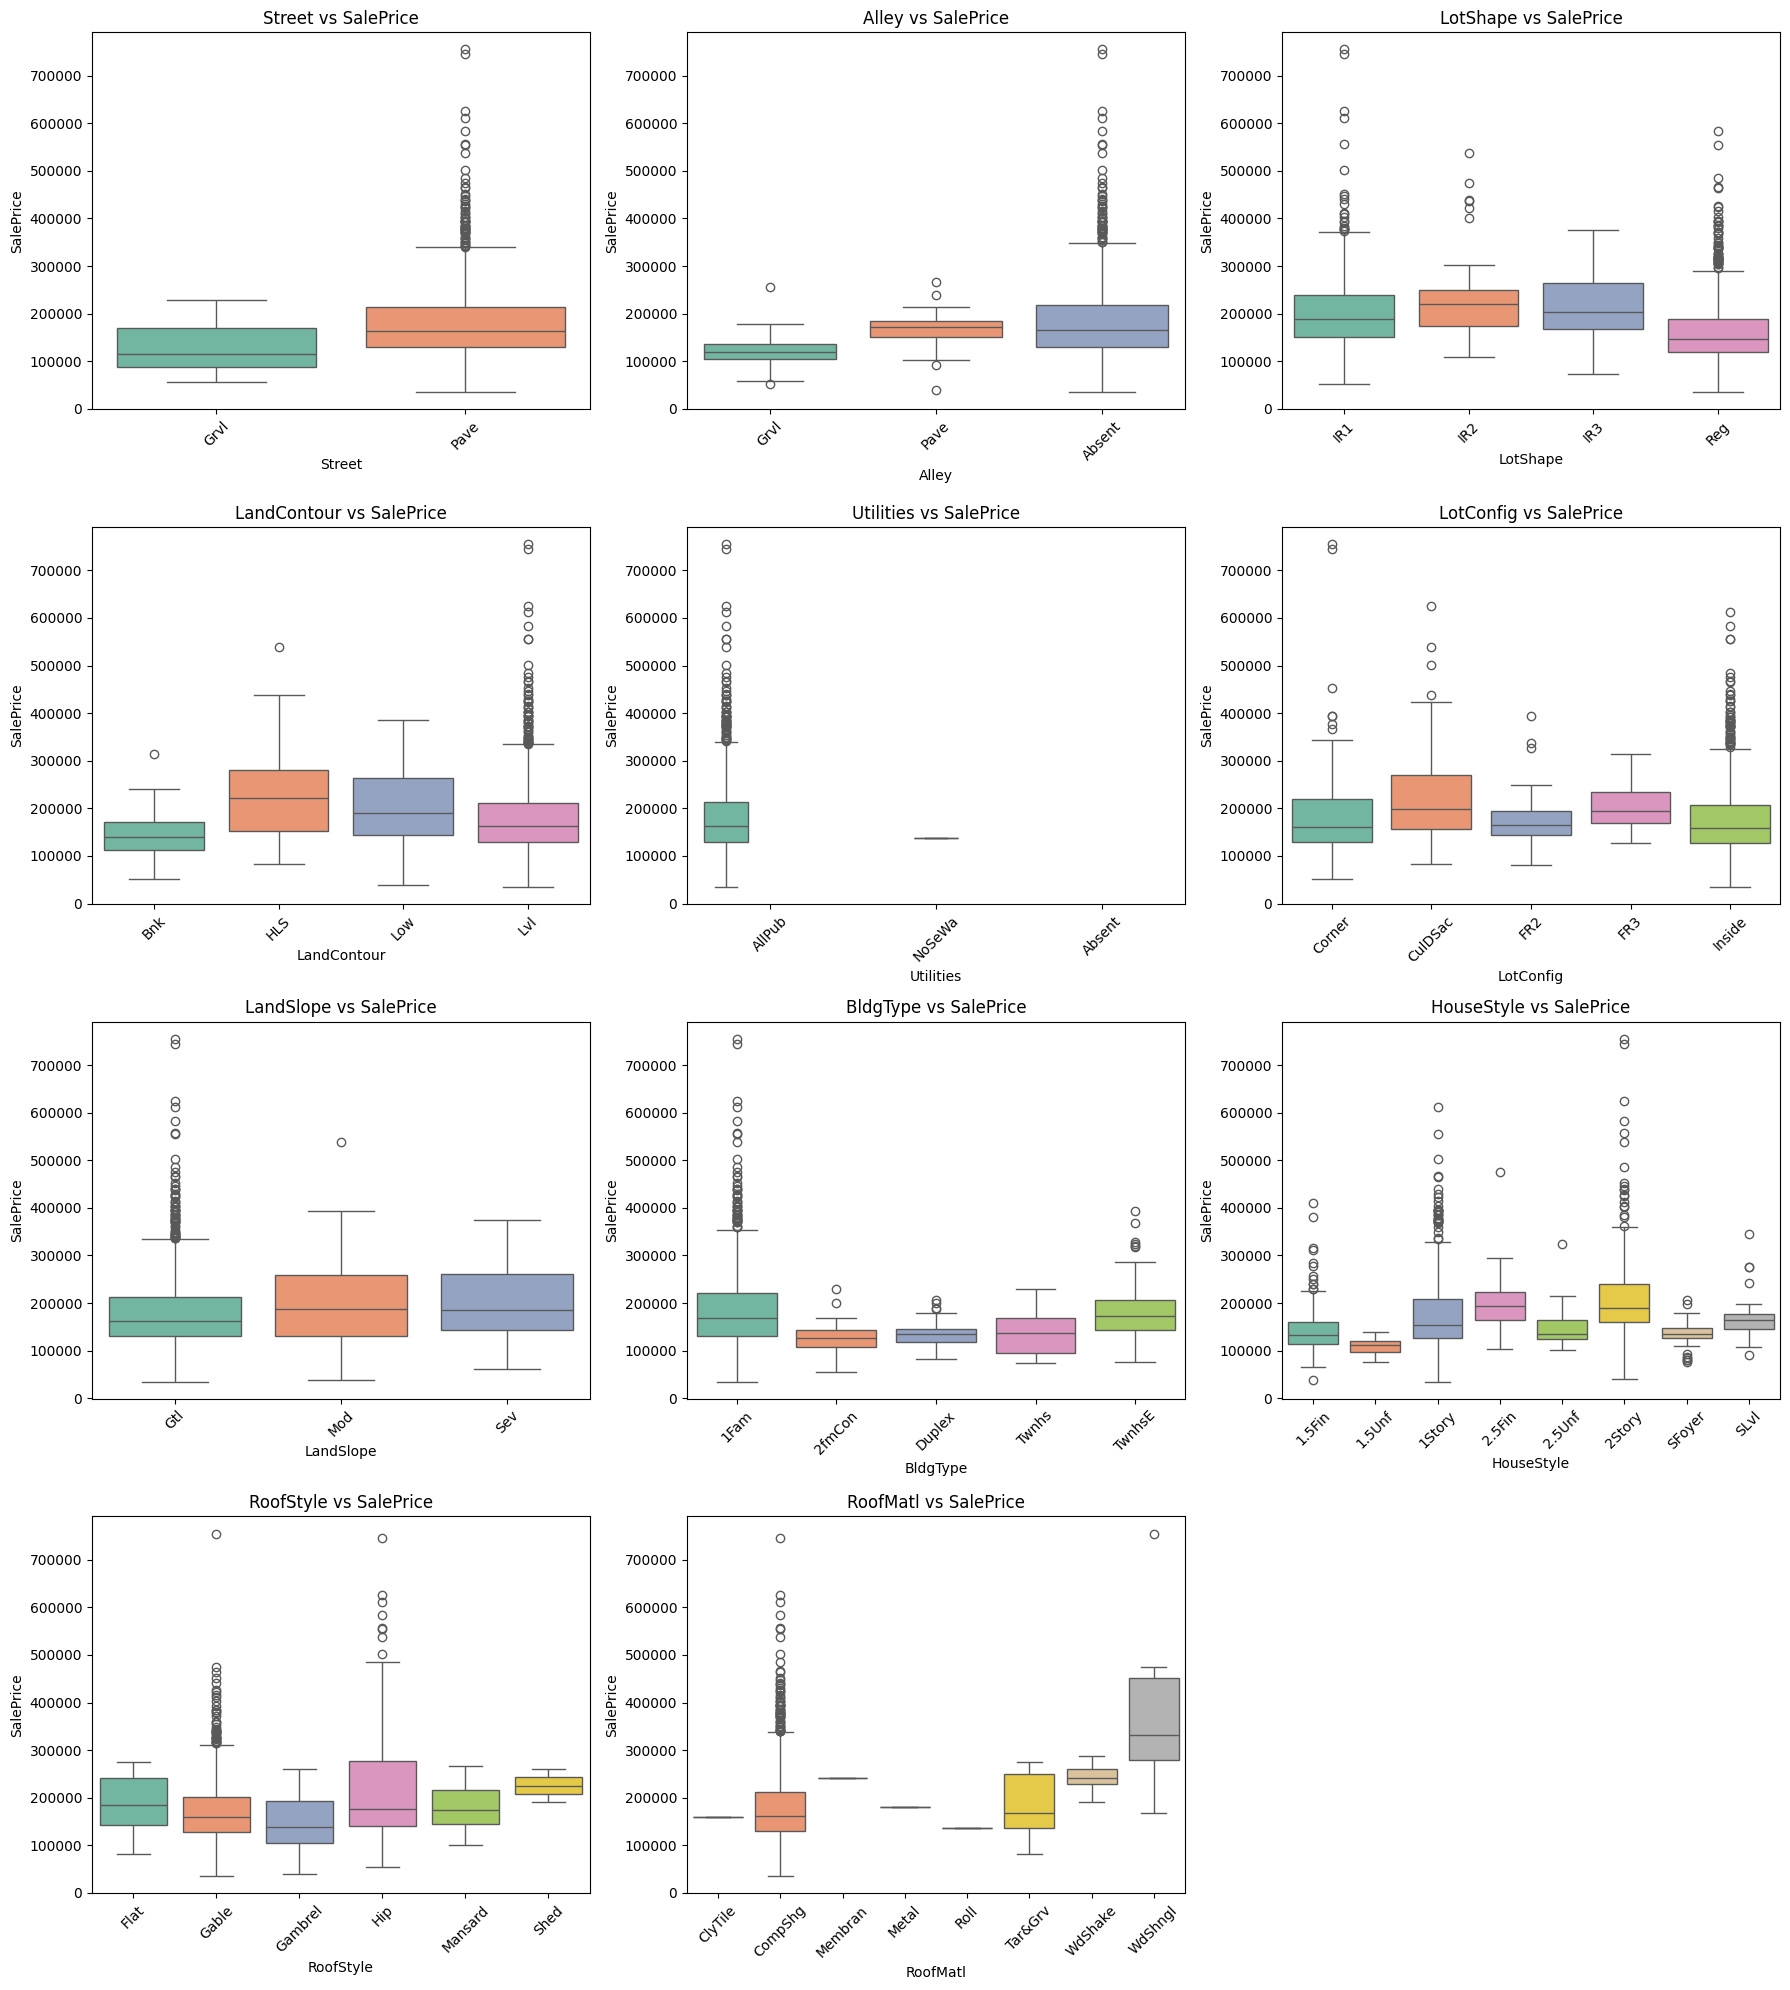

In [ ]:
columns_to_plot = ['Street', 'Alley', 'LotShape', 'LandContour',
                    'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl']
plot_boxplots(train, columns_to_plot)

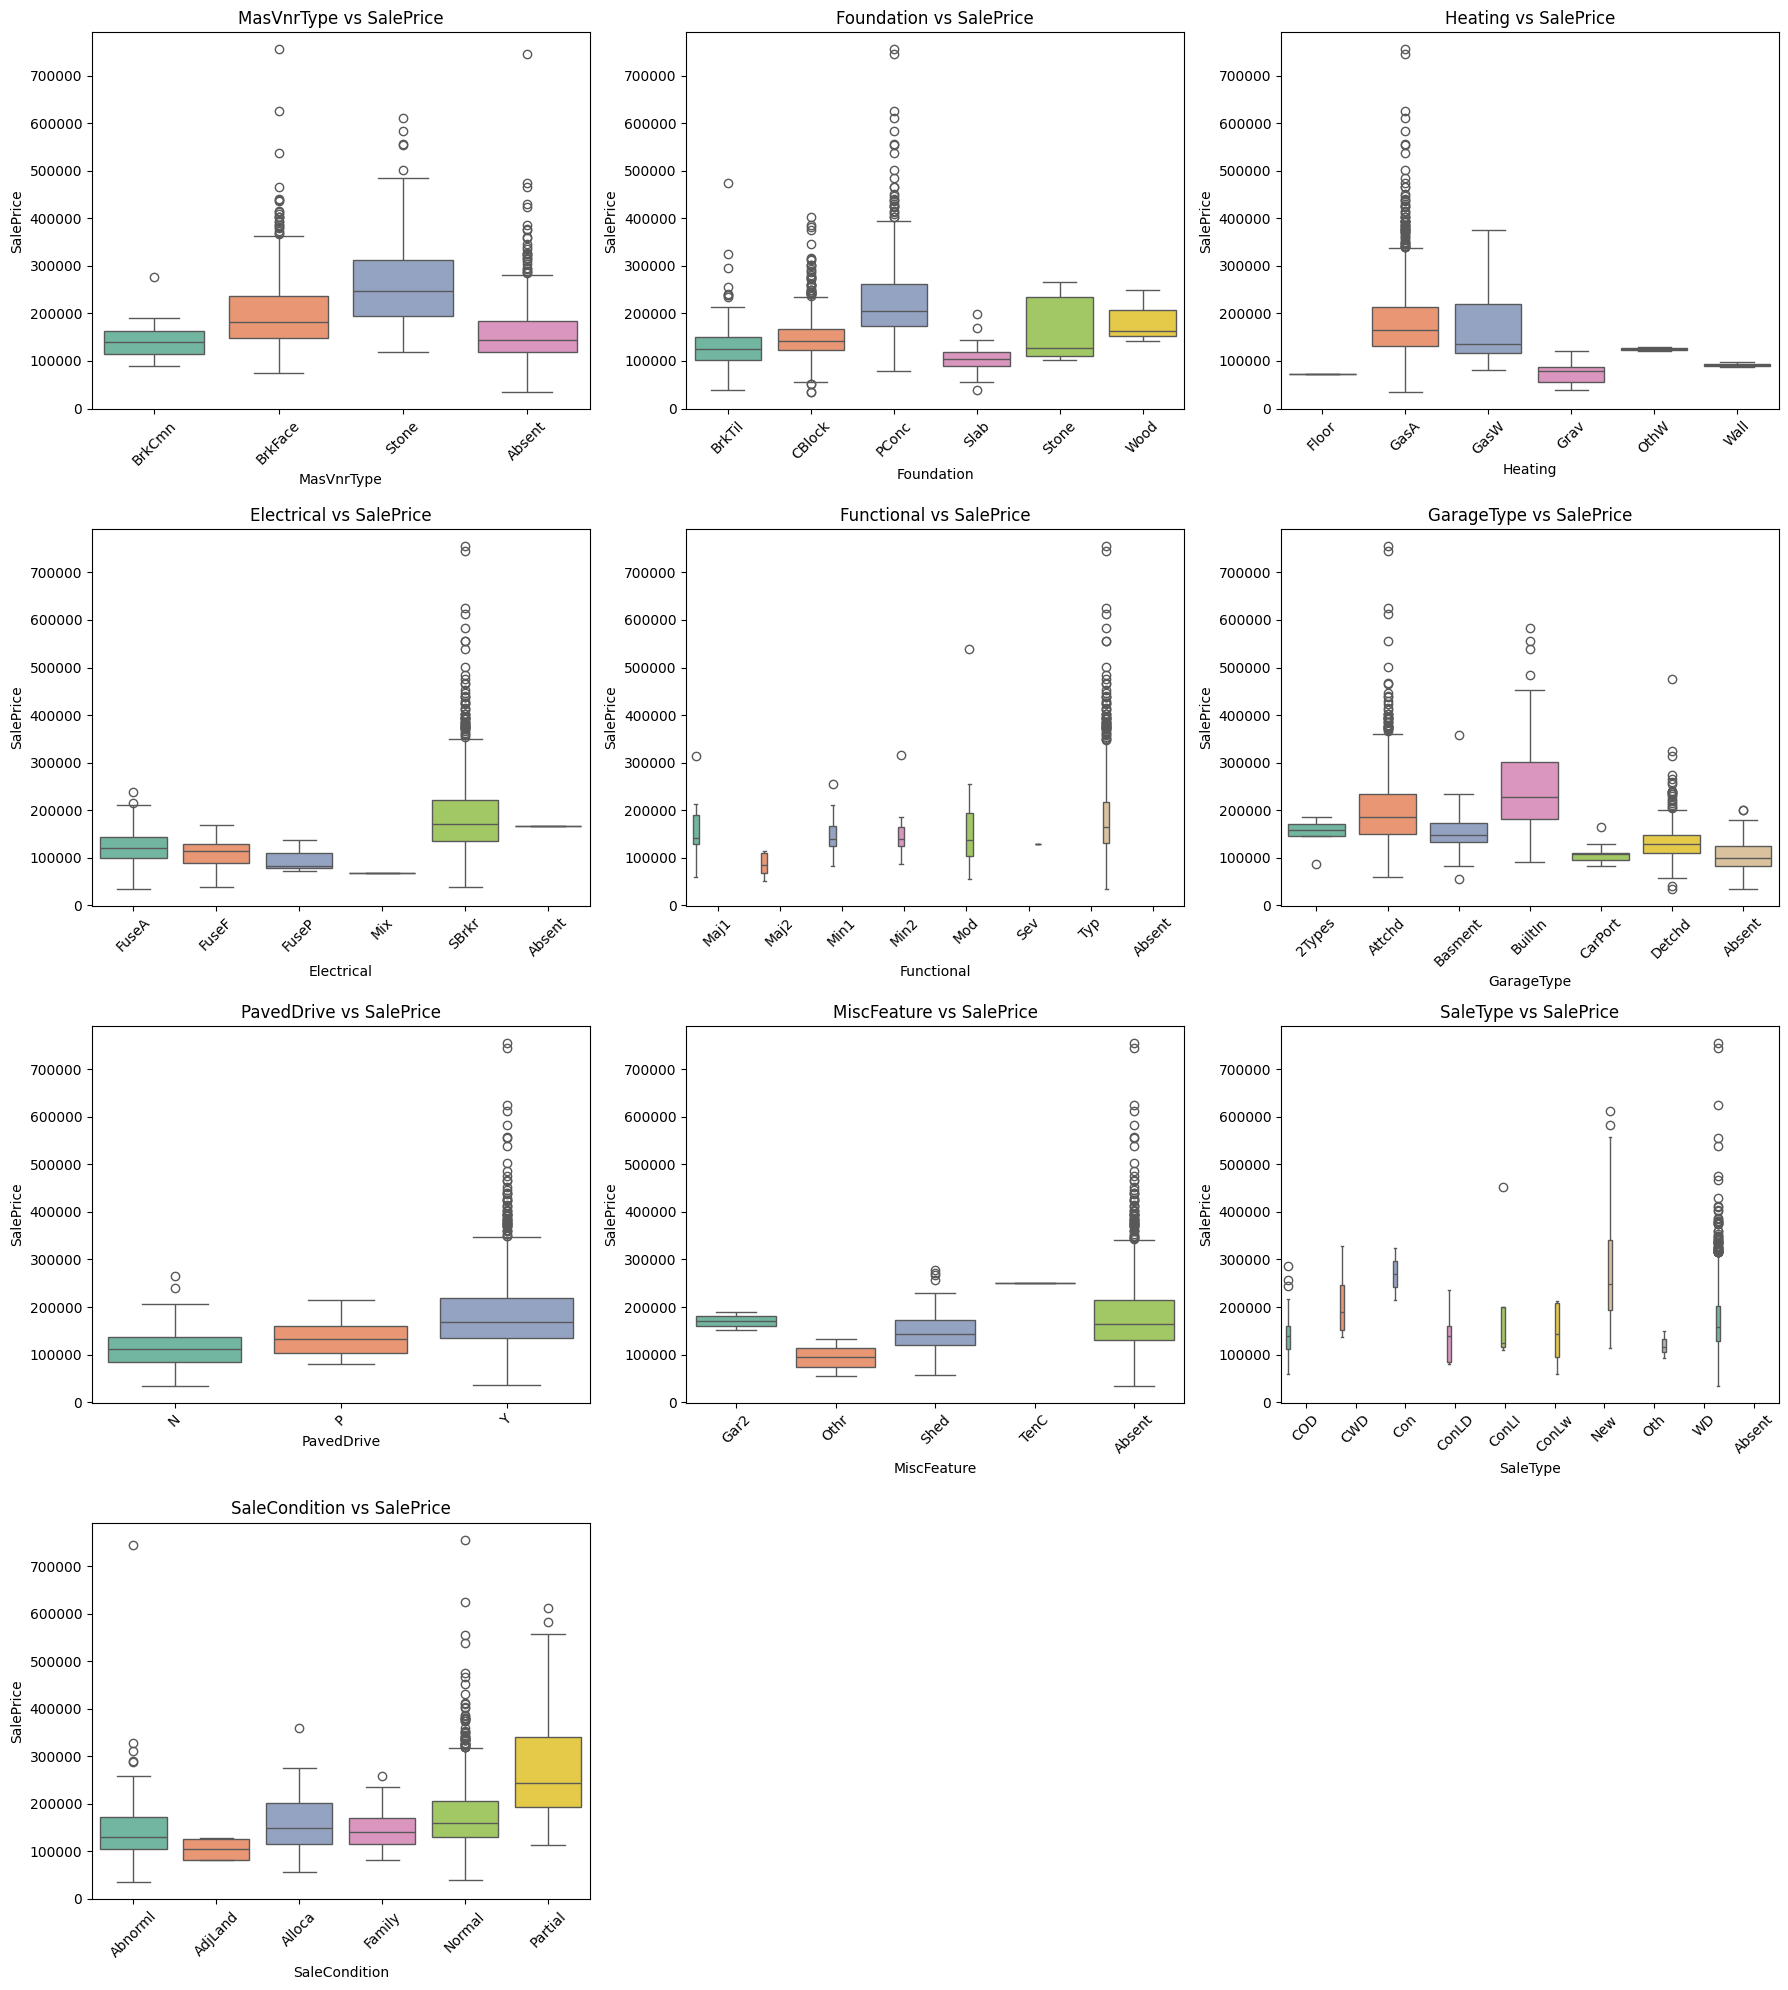

In [ ]:
columns_to_plot = ['MasVnrType', 'Foundation', 'Heating', 'Electrical','Functional', 'GarageType', 'PavedDrive','MiscFeature',
                   'SaleType','SaleCondition']
plot_boxplots(train, columns_to_plot)

Ordinal encoding of the categorical variables are done according the domain knowledge and real life significance

In [ ]:
order_mappings = {
    'Street': {'Grvl' : 1, 'Pave' : 2},
    'Alley': {'Grvl': 1, 'Pave': 2, 'Absent': 0},
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},
    'LandContour': {'Lvl': 4, 'Bnk': 3, 'Low': 1, 'HLS': 2},
    'Utilities': {'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0,'Absent': 0 },
    'LotConfig': {'Inside': 1, 'FR2': 3, 'Corner': 2, 'CulDSac': 5, 'FR3':4},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'BldgType': { '1Fam': 5, 'TwnhsE': 4, 'Twnhs': 3, 'Duplex': 2, '2fmCon': 1},
    'HouseStyle':{ '2.5Fin': 8, '2Story': 7, '1.5Fin': 6, 'SLvl': 5, 'SFoyer': 4, '1Story': 3, '2.5Unf': 2, '1.5Unf': 1},
    'RoofStyle': {'Mansard': 6, 'Hip': 5, 'Gable': 4, 'Gambrel': 3, 'Shed': 2, 'Flat': 1 },
    'RoofMatl': {'ClyTile': 8, 'WdShngl': 7, 'WdShake': 6, 'Metal': 5, 'Membran': 4, 'CompShg': 3, 'Tar&Grv': 2, 'Roll':1},
    'MasVnrType': {'Stone': 5, 'BrkFace': 4, 'BrkCmn': 3, 'CBlock': 2, 'Absent': 0},
    'Foundation': { 'PConc': 6, 'BrkTil': 5, 'Stone': 4, 'CBlock': 3, 'Wood': 2, 'Slab': 1},
    'Heating': { 'GasA': 6, 'GasW': 5, 'OthW': 4, 'Floor': 3, 'Wall': 2, 'Grav': 1},
    'Electrical': { 'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1, 'Absent':0},
    'Functional': { 'Typ': 8, 'Min1': 7,'Min2': 6, 'Mod': 5, 'Maj1': 4,'Maj2': 3, 'Sev': 2, 'Sal': 1, 'Absent': 0},
    'GarageType': { 'Attchd': 6,'BuiltIn': 5,'2Types': 4, 'Basment': 3,'Detchd': 2,'CarPort': 1,'Absent': 0},
    'PavedDrive': { 'Y': 3, 'P': 2, 'N': 1},
    'SaleType': { 'WD': 10, 'CWD': 9, 'VWD': 8,  'New': 7,'Con': 6,'ConLw': 5,'ConLI': 4, 'ConLD': 3,'COD': 2,'Oth': 1,'Absent': 0 },
    'SaleCondition': {'Normal': 6,'Abnorml': 5,'AdjLand': 4,'Alloca': 3,'Family': 2,'Partial': 1},
    'Fence': {'GdPrv': 4, 'GdWo': 3,'MnPrv': 2, 'MnWw': 1, 'Absent': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'Absent': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'Absent': 0}
}


In [ ]:
for col, col_mapping in order_mappings.items():
    if col in data.columns:
        data[col] = data[col].replace('Nan', 'Absent')
        data[col] = data[col].map(col_mapping)
        data[col] = data[col].astype('int64')

Jonckheere-Terpstra test, a non parametric test, is used to validate the ordinal encodings

In [ ]:
def jonckheere_terpstra_manual(data, cat_col, target_col):
    data_filtered = data[[cat_col, target_col]].dropna()
    sorted_categories = data_filtered.groupby(cat_col, observed = True)[target_col].median().sort_values().index
    groups = [data_filtered[data_filtered[cat_col] == cat][target_col].values for cat in sorted_categories]
    JT = 0
    for i in range(len(groups) - 1):
        for j in range(i + 1, len(groups)):
            for x in groups[i]:
                for y in groups[j]:
                    if x < y:
                        JT += 1
                    elif x == y:
                        JT += 0.5
    N = sum(len(g) for g in groups)
    E_JT = N * (N - 1) / 4
    term1 = N * (N - 1) * (2 * N + 5)
    tie_correction = sum(len(g) * (len(g) - 1) * (2 * len(g) + 5) for g in groups)
    Var_JT = (term1 - tie_correction) / 72
    Z = (JT - E_JT) / np.sqrt(Var_JT)
    p_value = norm.cdf(Z)
    return JT, p_value

In [ ]:
# List of categorical columns to test
cols = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle',
        'RoofStyle', 'RoofMatl','MasVnrType', 'Foundation', 'Heating', 'Electrical','Functional', 'GarageType', 'PavedDrive',
        'SaleType','SaleCondition','Fence','BsmtFinType1','BsmtFinType2']
results = []
for col in cols:
    JT_stat, p_val = jonckheere_terpstra_manual(train, col, 'SalePrice')
    results.append({'Variable': col, 'JT Statistic': JT_stat, 'P-value': round(p_val, 4)})

results_df = pd.DataFrame(results)
print(results_df)

         Variable  JT Statistic  P-value
0          Street        6165.5   0.0000
1           Alley       83416.0   0.0000
2        LotShape      356273.0   0.0000
3     LandContour      130198.5   0.0000
4       Utilities         998.5   0.0000
5       LotConfig      265935.0   0.0000
6       LandSlope       61213.5   0.0000
7        BldgType      196417.0   0.0000
8      HouseStyle      458484.0   0.0000
9       RoofStyle      228625.5   0.0000
10       RoofMatl       26142.0   0.0000
11     MasVnrType      422058.0   0.0000
12     Foundation      512652.5   0.0095
13        Heating       34013.5   0.0000
14     Electrical      137228.0   0.0000
15     Functional       91077.0   0.0000
16     GarageType      495577.5   0.0000
17     PavedDrive      129371.0   0.0000
18       SaleType      192567.5   0.0000
19  SaleCondition      244595.5   0.0000
20          Fence      228916.5   0.0000
21   BsmtFinType1      577390.0   1.0000
22   BsmtFinType2      171088.0   0.0000


Based on the p-values we reject the null hypothesis of irrelevant encoding with respect to price.

In [ ]:
data = data.drop(['MSSubClass','Exterior1st','Exterior2nd', 'MSZoning', 'YearRemodAdd'], axis=1)

One-hot encoding the remaining Categorical variables.

In [ ]:
data = pd.get_dummies(data, columns=['CentralAir'], drop_first=True)
data = pd.get_dummies(data, columns=['PoolQC'], drop_first=True)
data = pd.get_dummies(data, columns=['MiscFeature'])
data = data.drop(columns=['MiscFeature_Absent'])
data['CentralAir_Y'] = data['CentralAir_Y'].astype(int)
misc_feature_cols = [col for col in data.columns if col.startswith('MiscFeature_')]
data[misc_feature_cols] = data[misc_feature_cols].astype(int)

# MODEL FITTING

In [ ]:
num_cols = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'MasVnrArea',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'HouseAge', 'GarageAge']

In [ ]:
def evaluate_model(model_name, y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n📊 {model_name} Model Performance:")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ R² Score: {r2:.4f}")

In [ ]:
for col in data.columns:
  if(data[col].dtype == 'bool'):
    data[col] = data[col].astype('int64')

In [ ]:
train  = data[data['Dataset'] == 'train']
test = data[data['Dataset'] == 'test']
train = train.drop('Dataset', axis=1)
test = test.drop('Dataset', axis=1)
train['logSalePrice'] = np.log(train['SalePrice'])

In [ ]:
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.fit_transform(test[num_cols])

In [ ]:
x = train.drop(['SalePrice', 'logSalePrice', 'Id'], axis=1)
y = train['logSalePrice']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           logSalePrice   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     171.7
Date:                Sat, 09 Aug 2025   Prob (F-statistic):               0.00
Time:                        08:44:57   Log-Likelihood:                 933.65
No. Observations:                1460   AIC:                            -1723.
Df Residuals:                    1388   BIC:                            -1343.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.6292      0.262  

In [ ]:
vif = pd.DataFrame()
vif["Feature"] = x.columns
vif["VIF"] = [variance_inflation_factor(x.values, i)
              for i in range(x.shape[1])]
pd.set_option('display.max_rows', None)
print(vif.sort_values(by="VIF", ascending=False).reset_index(drop=True))

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


             Feature          VIF
0         BsmtFinSF1          inf
1          BsmtUnfSF          inf
2        TotalBsmtSF          inf
3       LowQualFinSF          inf
4           2ndFlrSF          inf
5           1stFlrSF          inf
6          GrLivArea          inf
7         BsmtFinSF2          inf
8              const  5827.554931
9           PoolArea    91.099686
10          PoolQC_4    44.536124
11          PoolQC_2    34.392033
12          PoolQC_5    23.839024
13           MiscVal     8.672722
14  MiscFeature_Gar2     8.076062
15          HouseAge     7.144251
16        GarageCars     6.246680
17        GarageArea     6.098089
18        HouseStyle     5.584710
19      TotRmsAbvGrd     5.377171
20         GarageAge     5.289127
21       FireplaceQu     5.056354
22        Fireplaces     4.928797
23       OverallQual     4.117770
24          BsmtQual     3.633814
25         ExterQual     3.326452
26      BsmtFinType2     3.090787
27          FullBath     3.071859
28     Neighbo

In [ ]:
train = train.drop(['PoolArea', 'PoolQC_4', 'PoolQC_2', 'PoolQC_5', 'TotalBsmtSF', '2ndFlrSF', '1stFlrSF'], axis = 1)

### ELASTIC NET REGRESSION MODEL

In [ ]:
# Setup
x = train.drop(['SalePrice', 'logSalePrice', 'Id', 'OverallQual'], axis=1)
y = train['logSalePrice']
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 1. 🔍 Grid Search to find best alpha and l1_ratio
param_grid = {
    'alpha': np.logspace(-3, 2, 50),
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
}
grid_search = GridSearchCV(ElasticNet(max_iter=10000), param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x, y)
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
print(f"✅ Best Alpha: {best_alpha:.5f}, Best L1 Ratio: {best_l1_ratio}")

# 2. 🚀 Evaluate using those best hyperparameters
fold = 1
rmse_scores = []
r2_scores = []

for train_index, val_index in kf.split(x):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit model with best parameters
    final_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000)
    final_model.fit(x_train, y_train)
    y_pred_log = final_model.predict(x_val)

    # 🔁 Duan Smearing correction
    residuals = y_train - final_model.predict(x_train)
    smearing_factor = np.mean(np.exp(residuals))
    y_pred_actual = np.exp(y_pred_log) * smearing_factor
    y_val_actual = np.exp(y_val)

    # 🧮 Evaluate
    rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_actual))
    r2 = r2_score(y_val_actual, y_pred_actual)

    print(f"\n📂 Fold {fold}")
    print(f"✅ RMSE (Duan corrected): {rmse:.4f}")
    print(f"✅ R² Score (Duan corrected): {r2:.4f}")

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    fold += 1

# 3. 📈 Summary
print("\n📈 Cross-Validation Summary (Duan corrected):")
print(f"✅ Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"✅ Average R² Score: {np.mean(r2_scores):.4f}")

✅ Best Alpha: 0.00256, Best L1 Ratio: 1.0

📂 Fold 1
✅ RMSE (Duan corrected): 28708.6929
✅ R² Score (Duan corrected): 0.9098

📂 Fold 2
✅ RMSE (Duan corrected): 27000.7012
✅ R² Score (Duan corrected): 0.8819

📂 Fold 3
✅ RMSE (Duan corrected): 23999.8277
✅ R² Score (Duan corrected): 0.8969

📂 Fold 4
✅ RMSE (Duan corrected): 29107.8163
✅ R² Score (Duan corrected): 0.8939

📂 Fold 5
✅ RMSE (Duan corrected): 43891.2835
✅ R² Score (Duan corrected): 0.6218

📂 Fold 6
✅ RMSE (Duan corrected): 105759.5925
✅ R² Score (Duan corrected): -0.8908

📂 Fold 7
✅ RMSE (Duan corrected): 32509.1705
✅ R² Score (Duan corrected): 0.8539

📂 Fold 8
✅ RMSE (Duan corrected): 24493.8889
✅ R² Score (Duan corrected): 0.8870

📂 Fold 9
✅ RMSE (Duan corrected): 24877.0311
✅ R² Score (Duan corrected): 0.8788

📂 Fold 10
✅ RMSE (Duan corrected): 20545.3901
✅ R² Score (Duan corrected): 0.9210

📈 Cross-Validation Summary (Duan corrected):
✅ Average RMSE: 36089.3395
✅ Average R² Score: 0.6854


count       146.000000
mean     181158.308219
std       73361.388233
min       52500.000000
25%      135000.000000
50%      164995.000000
75%      202700.000000
max      538000.000000
Name: logSalePrice, dtype: float64


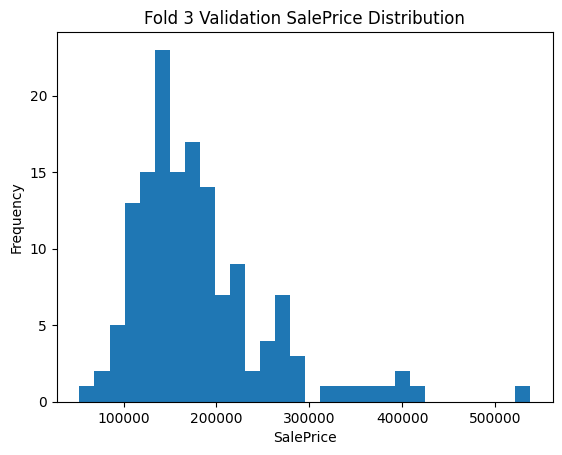

In [ ]:
# Optional: Pull Fold 3 Data again
x_val_3 = x.iloc[val_index]  # same indices used in fold 3
y_val_3 = y.iloc[val_index]

# Backtransform log(y)
y_val_3_actual = np.exp(y_val_3)

# Summary statistics
print(y_val_3_actual.describe())

# Plot distribution
plt.hist(y_val_3_actual, bins=30)
plt.title("Fold 3 Validation SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()


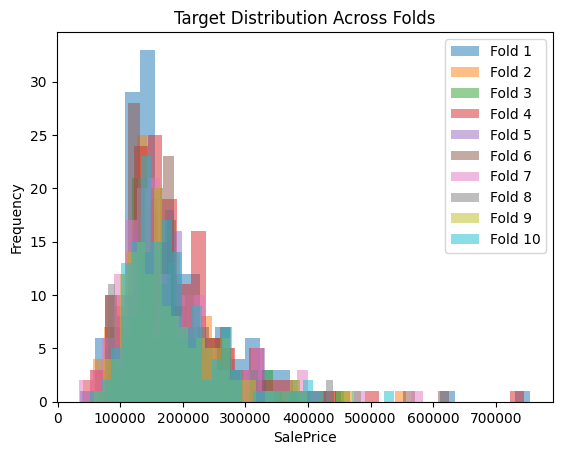

In [ ]:
for i, (_, val_idx) in enumerate(kf.split(x)):
    y_val_fold = np.exp(y.iloc[val_idx])
    plt.hist(y_val_fold, bins=30, alpha=0.5, label=f'Fold {i+1}')

plt.legend()
plt.title("Target Distribution Across Folds")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()


In [ ]:
feature_names = x.columns
coefficients = final_model.coef_
intercept = final_model.intercept_
nonzero_indices = np.where(coefficients != 0)[0]
nonzero_features = [(feature_names[i], coefficients[i]) for i in nonzero_indices]
nonzero_features_sorted = sorted(nonzero_features, key=lambda x: abs(x[1]), reverse=True)
print("\n📌 Nonzero Coefficients (Sorted):")
print(len(nonzero_features))
for name, coef in nonzero_features_sorted:
    print(f"{name}: {coef:.4f}")


📌 Nonzero Coefficients (Sorted):
43
GrLivArea: 0.1279
CentralAir_Y: 0.0843
Neighbourhood: 0.0731
KitchenQual: 0.0501
Functional: 0.0344
GarageCars: 0.0319
BsmtQual: 0.0288
ExterQual: 0.0286
HeatingQC: 0.0235
TotRmsAbvGrd: 0.0232
BsmtExposure: 0.0212
loc_proximity: 0.0178
ScreenPorch: 0.0176
BsmtFullBath: 0.0175
HouseStyle: -0.0143
FullBath: 0.0143
FireplaceQu: 0.0141
GarageQual: 0.0140
KitchenAbvGr: -0.0114
BsmtFinType1: 0.0113
GarageArea: 0.0107
LotArea: 0.0097
WoodDeckSF: 0.0096
Fireplaces: 0.0078
LotConfig: 0.0078
BldgType: 0.0077
HalfBath: 0.0069
PavedDrive: 0.0058
GarageType: 0.0050
BedroomAbvGr: 0.0046
3SsnPorch: 0.0043
GarageFinish: 0.0025
BsmtFinSF2: 0.0020
OpenPorchSF: 0.0018
SaleCondition: -0.0016
LowQualFinSF: -0.0008
MoSold: 0.0008
Foundation: 0.0007
BsmtUnfSF: 0.0006
SaleType: 0.0005
MasVnrType: 0.0004
BsmtHalfBath: 0.0001
MiscVal: 0.0000


### XGBOOST MODEL

In [ ]:
# 1) Prepare data
train  = data[data['Dataset'] == 'train']
train = train.drop('Dataset', axis=1)
train['logSalePrice'] = np.log(train['SalePrice'])
x = train.drop(['SalePrice', 'logSalePrice', 'Id', 'OverallQual'], axis=1)
y = train['SalePrice']

# 2) Parameter space for randomized search
param_dist = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.02, 0.05],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 1, 5],
    'reg_lambda': [1, 5, 10],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8]
}

# 3) Outer CV setup
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores, r2_scores = [], []
best_param_list = []

for fold, (tr_idx, val_idx) in enumerate(outer_cv.split(x), 1):
    X_train, X_val = x.iloc[tr_idx], x.iloc[val_idx]
    y_train, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # 4) Randomized search (NO early stopping)
    search = RandomizedSearchCV(
        estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
        param_distributions=param_dist,
        n_iter=15,
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    best_params = search.best_params_
    best_param_list.append(best_params)

    print(f"\n✅ Fold {fold} Best Params: {best_params}")

    # 5) Final model training with best params
    final_model = XGBRegressor(objective='reg:squarederror', **best_params)
    final_model.fit(X_train, y_train)

    # 6) Predictions and Evaluation
    y_pred = final_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    print(f"📂 Fold {fold} RMSE: {rmse:,.0f} | R²: {r2:.4f}")
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# 7) Overall Performance
print(f"\n🔥 Final RMSE: {np.mean(rmse_scores):,.0f} ± {np.std(rmse_scores):,.0f}")
print(f"🔥 Final R²: {np.mean(r2_scores):.4f}")

# 8) Summary of best hyperparameters across folds
param_summary = {}
for key in best_param_list[0].keys():
    param_summary[key] = Counter([bp[key] for bp in best_param_list])

print("\n📊 Summary of Best Params Across Folds:")
pprint(param_summary)



✅ Fold 1 Best Params: {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
📂 Fold 1 RMSE: 26,849 | R²: 0.9060

✅ Fold 2 Best Params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
📂 Fold 2 RMSE: 24,591 | R²: 0.9111

✅ Fold 3 Best Params: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
📂 Fold 3 RMSE: 37,748 | R²: 0.7421

✅ Fold 4 Best Params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
📂 Fold 4 RMSE: 28,186 | R²: 0.8735

✅ Fold 5 Best Params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0

<Figure size 1000x600 with 0 Axes>

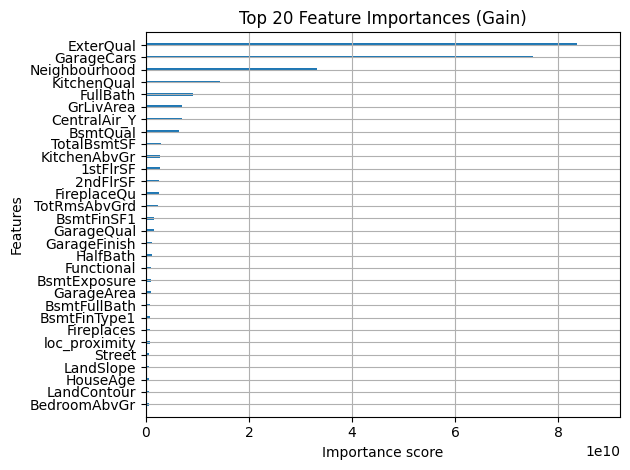

In [ ]:
from xgboost import XGBRegressor, plot_importance
import shap
final_model2 = XGBRegressor( objective='reg:squarederror', n_estimators=1000, max_depth=6, learning_rate=0.05, reg_alpha = 1, reg_lambda=1, colsample_bytree=0.8 , random_state=42)
final_model2.fit(x, y)
plt.figure(figsize=(10, 6))
plot_importance(final_model2, max_num_features=30, importance_type='gain', show_values=False)
plt.title("Top 20 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

 98%|===================| 1437/1460 [01:05<00:01]       

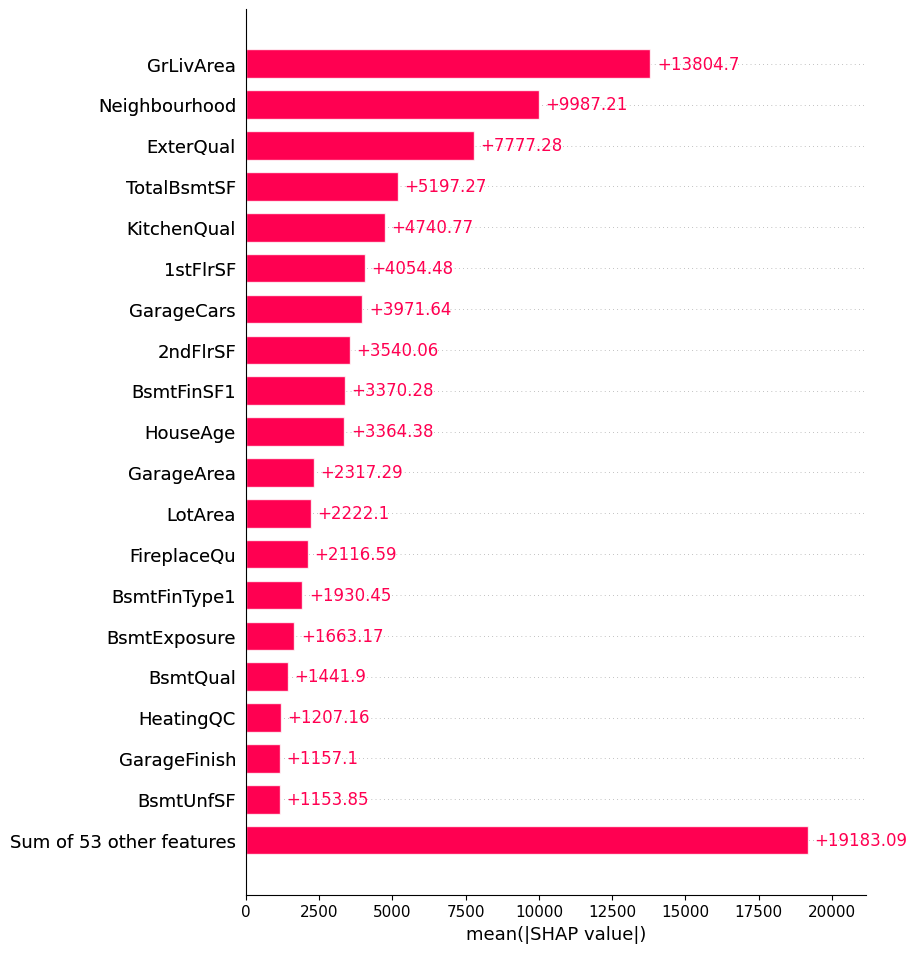

In [ ]:
shap.initjs()
import shap
import matplotlib.pyplot as plt

# Explainer for XGBoost
explainer = shap.Explainer(final_model2, x)

# SHAP values
shap_values = explainer(x)

# SHAP bar plot with both positive and negative contribution
shap.plots.bar(shap_values, max_display=20, show=True)  # auto handles positive/negative


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, KFold

# Your model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=6, learning_rate=0.05, reg_alpha=1, reg_lambda=1, colsample_bytree=0.8,
    random_state=42)

# Fit model to get feature importances
model.fit(x, y)

# Get feature importances by gain
booster = model.get_booster()
score_dict = booster.get_score(importance_type='gain')

# Map 'f0', 'f1', ... to actual column names
feature_map = {f"f{i}": col for i, col in enumerate(x.columns)}
sorted_items = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)
sorted_features = [feature_map.get(k, k) for k, _ in sorted_items]

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_errors = []

# Evaluate performance for top-K features in ranked order
for k in range(1, len(sorted_features) + 1):
    top_k_features = sorted_features[:k]
    x_subset = x[top_k_features]
    error = -np.mean(cross_val_score(
        model, x_subset, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1))
    cv_errors.append(error)


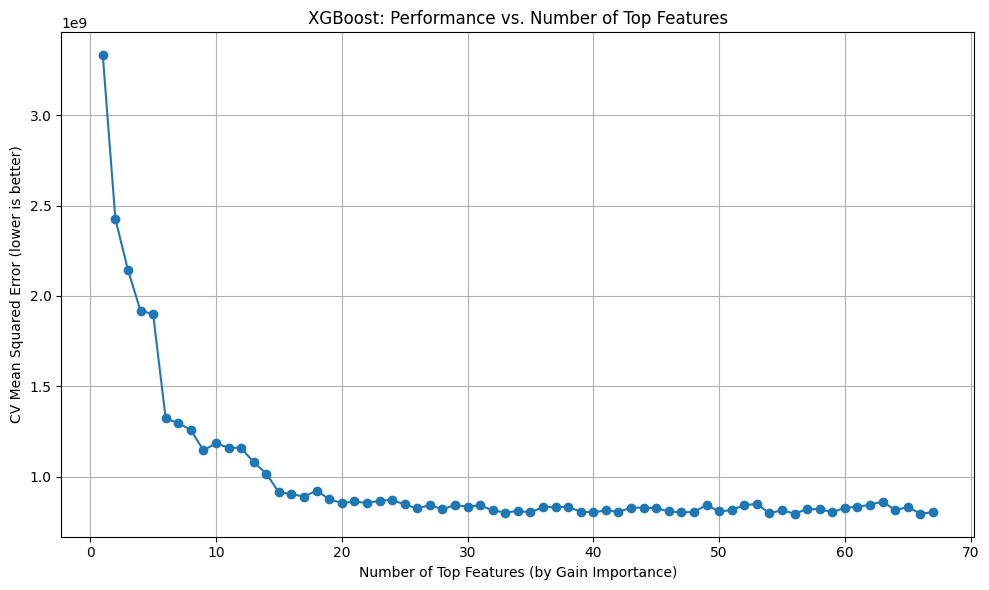

In [ ]:
# Plot performance vs number of top features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), cv_errors, marker='o')
plt.xlabel("Number of Top Features (by Gain Importance)")
plt.ylabel("CV Mean Squared Error (lower is better)")
plt.title("XGBoost: Performance vs. Number of Top Features")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Extract the top 20 features
top_20_features = sorted_features[:20]

# Print them
print("Top 20 features based on XGBoost gain importance:")
for i, feature in enumerate(top_20_features, 1):
    print(f"{i}. {feature}")

Top 20 features based on XGBoost gain importance:
1. ExterQual
2. GarageCars
3. Neighbourhood
4. KitchenQual
5. FullBath
6. GrLivArea
7. CentralAir_Y
8. BsmtQual
9. TotalBsmtSF
10. KitchenAbvGr
11. 1stFlrSF
12. 2ndFlrSF
13. FireplaceQu
14. TotRmsAbvGrd
15. BsmtFinSF1
16. GarageQual
17. GarageFinish
18. HalfBath
19. Functional
20. BsmtExposure


In [ ]:
x = train[top_20_features]
# 2. Define model
model_top20 = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    reg_alpha=1,
    reg_lambda=1,
    colsample_bytree=0.8,
    random_state=42
)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
rmse_list = []
r2_list = []

for train_index, val_index in kf.split(x):
    fold += 1
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model_top20.fit(x_train, y_train)
    y_pred = model_top20.predict(x_val)

    print(f"\n--- Fold {fold} ---")
    evaluate_model("XGBoost (Top 20 Features)", y_val, y_pred)

    # Now store the RMSE and R² separately
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    rmse_list.append(rmse)
    r2_list.append(r2)

# Final summary
print("\n📈 Cross-Validation Summary (Top 20 Features):")
for i in range(5):
    print(f"Fold {i+1}: RMSE = {rmse_list[i]:.4f}, R² = {r2_list[i]:.4f}")

print(f"\n✅ Mean RMSE: {np.mean(rmse_list):.4f}")
print(f"✅ Std Dev RMSE: {np.std(rmse_list):.4f}")
print(f"✅ Mean R² Score: {np.mean(r2_list):.4f}")


--- Fold 1 ---

📊 XGBoost (Top 20 Features) Model Performance:
✅ RMSE: 26480.9772
✅ R² Score: 0.9086

--- Fold 2 ---

📊 XGBoost (Top 20 Features) Model Performance:
✅ RMSE: 24601.2075
✅ R² Score: 0.9110

--- Fold 3 ---

📊 XGBoost (Top 20 Features) Model Performance:
✅ RMSE: 38836.7002
✅ R² Score: 0.7270

--- Fold 4 ---

📊 XGBoost (Top 20 Features) Model Performance:
✅ RMSE: 30492.3561
✅ R² Score: 0.8519

--- Fold 5 ---

📊 XGBoost (Top 20 Features) Model Performance:
✅ RMSE: 22992.0740
✅ R² Score: 0.8989

📈 Cross-Validation Summary (Top 20 Features):
Fold 1: RMSE = 26480.9772, R² = 0.9086
Fold 2: RMSE = 24601.2075, R² = 0.9110
Fold 3: RMSE = 38836.7002, R² = 0.7270
Fold 4: RMSE = 30492.3561, R² = 0.8519
Fold 5: RMSE = 22992.0740, R² = 0.8989

✅ Mean RMSE: 28680.6630
✅ Std Dev RMSE: 5661.5889
✅ Mean R² Score: 0.8595


In [ ]:
test_ids = test['Id']
test_features = test.drop(columns=['Id'])
test_features = sm.add_constant(test_features)
test_features = test_features[top_20_features]
test_pred = model_top20.predict(test_features)
pred_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_pred
})
pred_df.to_csv("final_predictions.csv", index=False)